# Projeto Mulheres Vítimas Versão 2.5
## Classificação de municípios com K-Means


**João L. S. Júnior**\
Universidade Federal do Pará - UFPA \
Laboratório de Pesquisa Operacional - LPO\
Instituto Federal de Educação, Ciência e Tecnologia do Pará - IFPA\
Copyright(c) 2023.


In [60]:
# Imports principais para tratamento de dados
import pandas as pd
import numpy as np
import requests as rq

# Para transformação em duas dimensões
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

# Para a geração de gráficos
import matplotlib.pyplot as plt
import seaborn as sns


# Define a paleta com 3 cores
#my_palette = sns.color_palette('Set1', n_colors=3)[::-1] # Inverte as cores da paleta
from matplotlib.colors import ListedColormap
#my_palette = sns.color_palette('Set1', n_colors=4)
my_palette = ListedColormap(list(reversed(['#54FF00', '#FFEB00', '#FF9500', '#FF0000'])))


## - Funções úteis - ##

# Função para formatar a url com os dados dos municípios.
def adicionar_municipios_a_url(url_original, df):
    url_saida = url_original + 'resultados/'    

    for i, row in df.iterrows():
        if i != (len(df)):
            url_saida += row.id + '|'
        else:
            url_saida += row.id + '/'
    
    return url_saida


# Função que transformas os dados em duas dimensões
def transformar_dados_duas_dimensoes(numeric_data, tipo):
    df_transformed = pd.DataFrame()

    if tipo == 1:
        tSVD  = TruncatedSVD(n_components = 2, n_iter = 100, random_state = 42)
        tSVD_data = tSVD.fit_transform(numeric_data)

        # Criar um novo DataFrame com os dados transformados
        df_transformed = pd.DataFrame(tSVD_data, columns=['Dimensão 1', 'Dimensão 2'])
    elif tipo == 2:
        # Aplicar o t-SNE para redução de dimensionalidade
        tsne = TSNE(n_components=2, random_state=42)
        tsne_data = tsne.fit_transform(numeric_data)

        # Criar um novo DataFrame com os dados transformados
        df_transformed = pd.DataFrame(tsne_data, columns=['Dimensão 1', 'Dimensão 2'])

    return df_transformed

---
### Inicialmente, vamos gerar um dataset com os nomes dos municípios, extraídos da API do IBGE ('http://servicodados.ibge.gov.br/api/v1/localidades/estados/pa/municipios')
---

In [61]:
# Busca na API do IBGE
url = 'http://servicodados.ibge.gov.br/api/v1/localidades/estados/pa/municipios'
res = rq.request("GET", url)

# Definição do dataset de municípios paraenses 'df_munic'
df_munic = pd.DataFrame({'id': [], 'localidade': []})

if res.status_code == 200:
    # Insere o resultados no dataFrame.
    for id, munic in enumerate(res.json()):
        if munic['nome'] != 'Mojuí dos Campos': # Excluir este município por falta de dados.
            df_munic.loc[id] = [str(munic['id'])[:6], munic['nome']]
else:
    print('Erro ao obter dados da API.')

df_munic


,id,localidade
0,150010,Abaetetuba
1,150013,Abel Figueiredo
2,150020,Acará
3,150030,Afuá
4,150034,Água Azul do Norte
...,...,...
139,150815,Uruará
140,150820,Vigia
141,150830,Viseu
142,150835,Vitória do Xingu


In [62]:
indicators = ['90201','90335','90358','90626','90640', '90272', '90397']

url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/1/periodos/2019/indicadores/"

for i, ind in enumerate(indicators):
    if i != (len(indicators)-1):
        url += ind + '|'
    else:
        url += ind + '/'
        
# Adiciona os nomes dos municípios à url original.
url = adicionar_municipios_a_url(url, df_munic)

# return json results
res = rq.request("GET", url)


In [63]:
ExcelentEquipaments = [90201, 90358, 90272]
GoodEquipaments = [90626, 90640]
okEquipaments = [90335, 90397]

if res.status_code == 200:
    
    #Scrolls through the json and inserts the data into the main dataframe for each selected indicator.
    for indicador in res.json():
        df_temp = pd.DataFrame(indicador['res'])
        df_temp = df_temp[['localidade', 'res']]
        df_temp.rename(columns = {'localidade':'id', 'res': indicador['id']}, inplace = True)
        
        #It replaces the words "Yes" and "No" with binary information 1 and 0.
        if indicador['id'] in ExcelentEquipaments:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 * 1.5 if x['2019']  == 'Sim' else 0)

        elif indicador['id'] in GoodEquipaments:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 * 0.5 if x['2019']  == 'Sim' else 0)

        else:
            df_temp[indicador['id']] = df_temp[indicador['id']].map(lambda x: 1 * 0.2 if x['2019']  == 'Sim' else 0)

        df_munic = pd.merge(df_munic, df_temp, on="id")

In [64]:
df_munic

,id,localidade,90201,90272,90335,90358,90397,90626,90640
0,150010,Abaetetuba,1.5,0.0,0.2,0.0,0.0,0.5,0.5
1,150013,Abel Figueiredo,0.0,0.0,0.0,0.0,0.0,0.0,0.5
2,150020,Acará,0.0,0.0,0.2,0.0,0.0,0.5,0.5
3,150030,Afuá,0.0,0.0,0.2,0.0,0.0,0.5,0.5
4,150034,Água Azul do Norte,0.0,0.0,0.0,0.0,0.0,0.0,0.5
...,...,...,...,...,...,...,...,...,...
138,150815,Uruará,0.0,0.0,0.2,0.0,0.0,0.0,0.0
139,150820,Vigia,0.0,0.0,0.0,0.0,0.0,0.0,0.0
140,150830,Viseu,0.0,0.0,0.2,0.0,0.0,0.0,0.0
141,150835,Vitória do Xingu,0.0,0.0,0.2,1.5,0.0,0.5,0.5


# IAP - Índice de Assistência e Proteção

In [65]:
# Calcula o índice IAP
df_munic['IAP'] = df_munic[90201] + df_munic[90272] + df_munic[90335] + df_munic[90358] + df_munic[90397] + df_munic[90626] + df_munic[90640]

# Seleciona somente as colunas principais
df_munic = df_munic[['id', 'localidade', 'IAP']]

In [66]:
df_munic

,id,localidade,IAP
0,150010,Abaetetuba,2.7
1,150013,Abel Figueiredo,0.5
2,150020,Acará,1.2
3,150030,Afuá,1.2
4,150034,Água Azul do Norte,0.5
...,...,...,...
138,150815,Uruará,0.2
139,150820,Vigia,0.0
140,150830,Viseu,0.2
141,150835,Vitória do Xingu,2.7


# IDH

In [67]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/37/periodos/2010/indicadores/30255/"

url = adicionar_municipios_a_url(url, df_munic)
        
res = rq.request("GET", url)

# correction of missing values
x = res.json()
x[0]['res'][73]['res']['2010'] = '0'
x

df_temp = pd.json_normalize(x[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2010': 'IDH'}, inplace=True)
df_temp = df_temp[['id', 'IDH']]
df_munic = pd.merge(df_munic, df_temp, on='id')

# PIB

In [68]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/38/periodos/2019/indicadores/47001/"

url = adicionar_municipios_a_url(url, df_munic)   
res = rq.request("GET", url)
df_temp = pd.json_normalize(res.json()[0]['res'])
df_temp.rename(columns={'localidade': 'id', 'res.2019': 'PIB'}, inplace=True)
df_temp = df_temp[['id', 'PIB']]
df_munic = pd.merge(df_munic, df_temp, on='id')

# GINI

In [69]:
url = "https://servicodados.ibge.gov.br/api/v1/pesquisas/36/periodos/2003/indicadores/30252/"

url = adicionar_municipios_a_url(url, df_munic)
        
res = rq.request("GET", url)
# correction of missing values
x = res.json()
x[0]['res'].append({'localidade': '150475', 'res': {'2003': '0.00'}, 'notas': {'2003': None}})

df_temp =  pd.json_normalize(x[0]['res'])

df_temp.rename(columns={'localidade': 'id', 'res.2003': 'GINI'}, inplace=True)
df_temp = df_temp[['id', 'GINI']]
df_munic = pd.merge(df_munic, df_temp, on='id', how='left')
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])
#df_munic['GINI'] = df_munic.iloc[:, 5:6].apply(lambda x: -x.abs(), axis=1)

In [70]:
df_munic

,id,localidade,IAP,IDH,PIB,GINI
0,150010,Abaetetuba,2.7,0.628,9458.72,0.40
1,150013,Abel Figueiredo,0.5,0.622,11420.76,0.37
2,150020,Acará,1.2,0.506,13582.97,0.36
3,150030,Afuá,1.2,0.489,9405.70,0.39
4,150034,Água Azul do Norte,0.5,0.564,15819.85,0.37
...,...,...,...,...,...,...
138,150815,Uruará,0.2,0.589,13401.03,0.38
139,150820,Vigia,0.0,0.617,7216.02,0.36
140,150830,Viseu,0.2,0.515,7952.36,0.37
141,150835,Vitória do Xingu,2.7,0.596,270414.24,0.38


In [71]:
df_munic['IAP'] = pd.to_numeric(df_munic['IAP'])
df_munic['IDH'] = pd.to_numeric(df_munic['IDH'])
df_munic['PIB'] = pd.to_numeric(df_munic['PIB'])
df_munic['GINI'] = pd.to_numeric(df_munic['GINI'])

# Normalização

In [72]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
import pandas as pd

# Define o normalizador
normalizador1 = PowerTransformer(method="yeo-johnson")
normalizador2 = QuantileTransformer(n_quantiles=100, output_distribution="normal", random_state=48, copy=True)

# Seleciona as colunas numéricas para normalização
colunas_para_normalizar_1 = ['IAP']
colunas_para_normalizar_2 = ['IDH', 'PIB', 'GINI']
colunas_para_normalizar = colunas_para_normalizar_1 + colunas_para_normalizar_2

# Cria uma cópia do DataFrame para evitar modificações no DataFrame original
df_normalizado = df_munic.copy()

# Normaliza cada coluna selecionada
df_normalizado[colunas_para_normalizar_1] = normalizador1.fit_transform(df_normalizado[colunas_para_normalizar_1])
df_normalizado[colunas_para_normalizar_2] = normalizador2.fit_transform(df_normalizado[colunas_para_normalizar_2])

# Mostra o novo DataFrame normalizado
df_normalizado


,id,localidade,IAP,IDH,PIB,GINI
0,150010,Abaetetuba,1.655035,0.872794,-0.283961,1.051717
1,150013,Abel Figueiredo,0.009898,0.764710,0.199599,-0.242903
2,150020,Acará,0.893807,-1.288789,0.393296,-0.604585
3,150030,Afuá,0.893807,-1.639976,-0.298733,0.650837
4,150034,Água Azul do Norte,0.009898,-0.269066,0.629123,-0.242903
...,...,...,...,...,...,...
138,150815,Uruará,-0.688651,0.165327,0.373610,0.203961
139,150820,Vigia,-1.389978,0.730403,-1.350526,-0.604585
140,150830,Viseu,-0.688651,-1.120205,-0.779782,-0.242903
141,150835,Vitória do Xingu,1.655035,0.379623,2.862648,0.203961


# Transformar os dados em duas dimensões

In [73]:
# Selecionar apenas as colunas numéricas
colunas_numericas = ['IAP', 'IDH', 'PIB', 'GINI']
dados_numericos = df_normalizado[colunas_numericas].values

df_duas_dimensoes = transformar_dados_duas_dimensoes(numeric_data=dados_numericos, tipo=1)



# Método do Cotovelo (Elbow Method)
### Utilizado para definir o melhor número de clusters

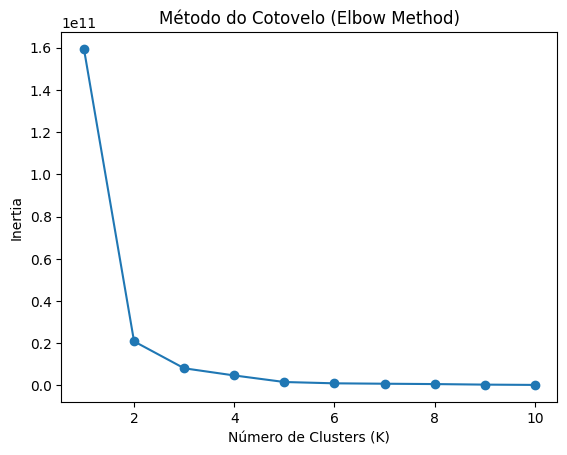

In [74]:
from sklearn.cluster import KMeans

# Implementa o Método do Cotovelo para determinar o valor ideal de K

inertia_values = [] # Lista para armazenar os valores da função de custo (inertia) para cada valor de K

# Executa o K-Means para diferentes valores de K (1 a 10)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(df_munic[colunas_numericas])
    inertia_values.append(kmeans.inertia_)

# Plot do Método do Cotovelo
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo (Elbow Method)')
plt.show()

# Classificação com o Método K-Means++
### Utilizado para definir o melhor posicionamento dos centróides


In [75]:
# Selecionando apenas as colunas com características numéricas para o k-means
# X = df_normalizado[colunas_para_normalizar]
X = df_duas_dimensoes

# Executando o K-Means++ com scikit-learn
numero_clusters = 4
kmeans = KMeans(n_clusters=numero_clusters, init='k-means++', random_state=42, n_init='auto')
df_normalizado['Cluster'] = kmeans.fit_predict(X)

# Obtendo os centróides encontrados pelo K-Means++
centroids = kmeans.cluster_centers_

# Obtendo os rótulos de cluster para cada ponto de dado
labels = kmeans.labels_

# Redefinindo a coluna "Cluster" como uma coluna regular
df_normalizado['Cluster'] = df_normalizado['Cluster'].astype(int)


# # Adicionar a coluna 'Cluster' ao DataFrame transformado
df_duas_dimensoes['Cluster'] = df_normalizado['Cluster'].astype(int)

# Visualizando o dataset com a adição da coluna de clusters
df_normalizado


,id,localidade,IAP,IDH,PIB,GINI,Cluster
0,150010,Abaetetuba,1.655035,0.872794,-0.283961,1.051717,3
1,150013,Abel Figueiredo,0.009898,0.764710,0.199599,-0.242903,1
2,150020,Acará,0.893807,-1.288789,0.393296,-0.604585,1
3,150030,Afuá,0.893807,-1.639976,-0.298733,0.650837,1
4,150034,Água Azul do Norte,0.009898,-0.269066,0.629123,-0.242903,1
...,...,...,...,...,...,...,...
138,150815,Uruará,-0.688651,0.165327,0.373610,0.203961,1
139,150820,Vigia,-1.389978,0.730403,-1.350526,-0.604585,0
140,150830,Viseu,-0.688651,-1.120205,-0.779782,-0.242903,0
141,150835,Vitória do Xingu,1.655035,0.379623,2.862648,0.203961,3


In [ ]:
df_normalizado.query('Cluster == 0').describe

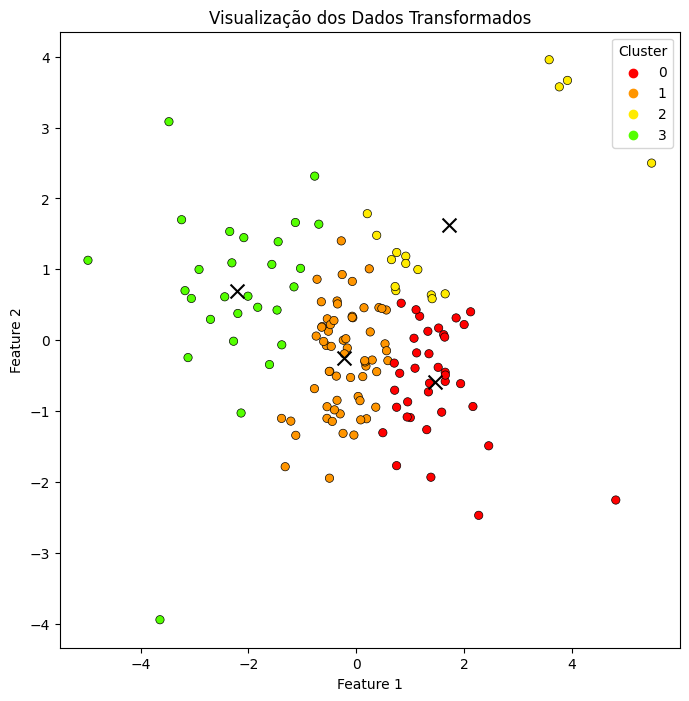

In [85]:
# Plotar o gráfico
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_duas_dimensoes, x='Dimensão 1', y='Dimensão 2', hue='Cluster', palette=my_palette, edgecolor="k")
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, marker='x')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualização dos Dados Transformados')
plt.show()


In [89]:
df_normalizado['Cluster'].value_counts()

1    62
0    37
3    28
2    16
Name: Cluster, dtype: int64

<Figure size 1200x800 with 0 Axes>

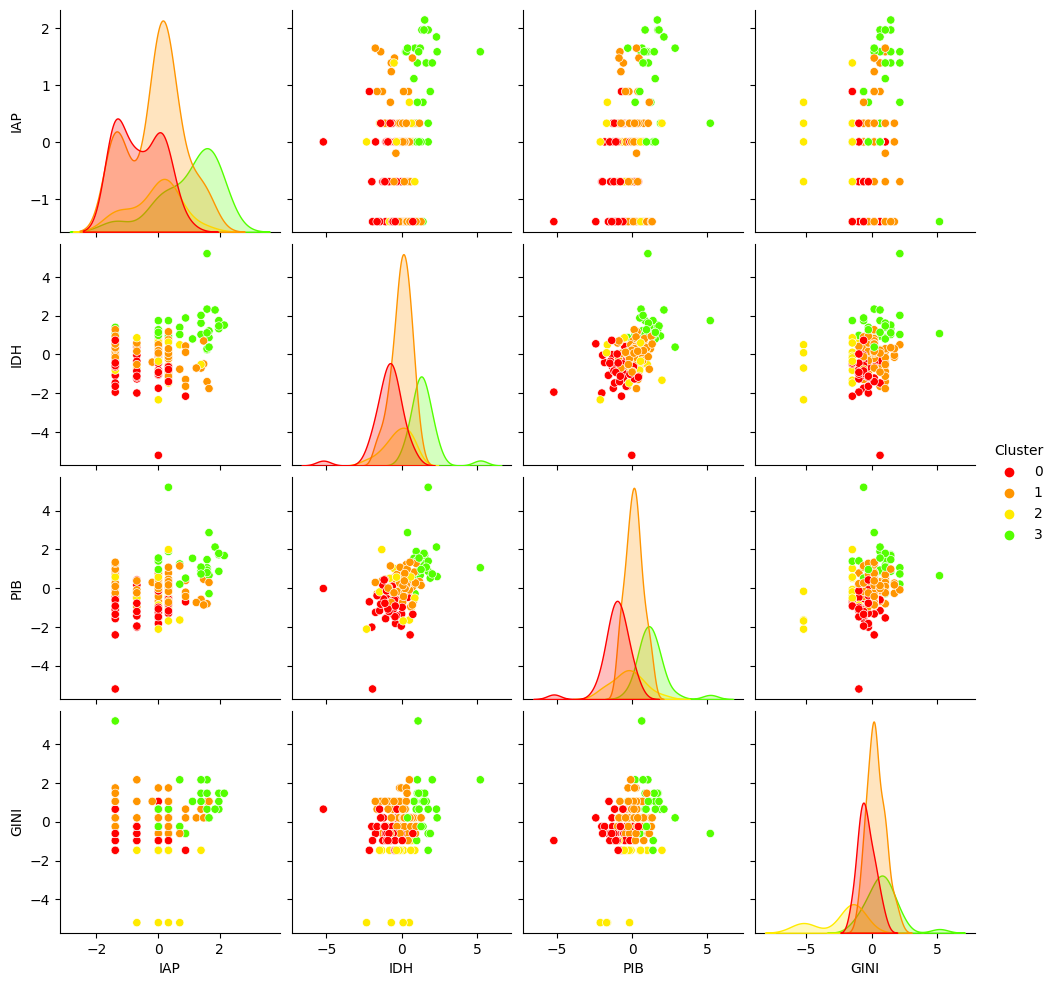

In [91]:
# Gráficos de dispersão múltiplos
import seaborn as sns

plt.figure(figsize=(12, 8))


sns.pairplot(df_normalizado.iloc[:, 2:], hue='Cluster', palette=my_palette.colors)
plt.show()

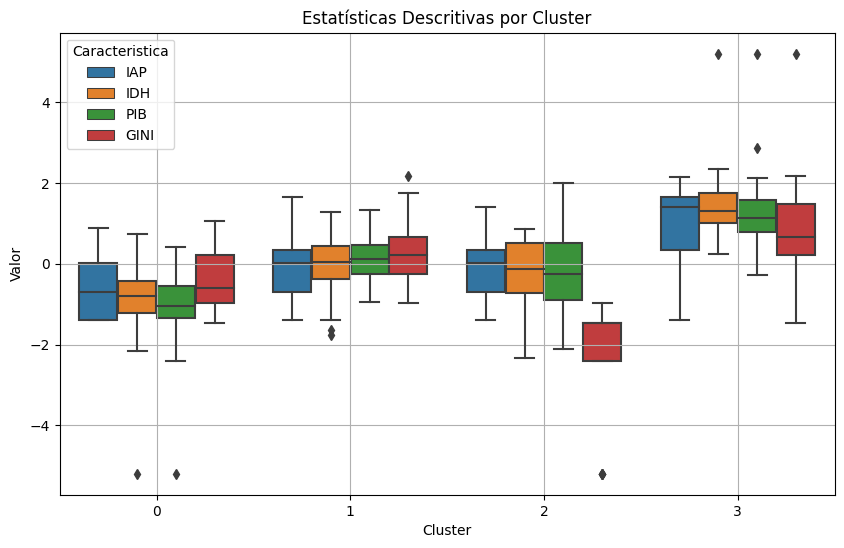

In [ ]:
# Convertendo os dados para formato "tidy"
df_tidy = df_normalizado.melt(id_vars=['Cluster', 'localidade'], value_vars=['IAP', 'IDH', 'PIB', 'GINI'],
                  var_name='Caracteristica', value_name='Valor')

# Plotando o gráfico de boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_tidy, x='Cluster', y='Valor', hue='Caracteristica')
plt.xlabel('Cluster')
plt.ylabel('Valor')
plt.title('Estatísticas Descritivas por Cluster')
plt.grid(True)
plt.show()